In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2

train_path = '/content/drive/MyDrive/recommendation sys data/data/train.csv'
test_path = '/content/drive/MyDrive/recommendation sys data/data/test.csv'

df = pd.read_csv(train_path)

EMBEDDING_SIZE = 50
BATCH_SIZE = 32
EPOCH = 3
LEARNING_RATE = 0.001

df.tail()

,userId,itemId,rating,date
8612102,blqyzd,148210,1,2017-08-05 14:15:09
8612103,blqyzd,735535,4,2017-08-05 14:14:35
8612104,blqyzd,124242,3,2017-08-05 14:25:33
8612105,blqyzd,948393,4,2017-08-05 13:25:21
8612106,blqyzd,163356,4,2017-08-05 14:24:57


In [2]:
# need to perform some preprocessing
# We Must change the userId column with numeric
def FeatureEncoderDecoder(value):
    encoder = {}
    decoder = {}
    for val, key in enumerate(value):
        encoder[key] = val
        decoder[val] = key
    return encoder, decoder

encoder, decoder = FeatureEncoderDecoder(df['userId'])
df['userId'] = df['userId'].map(encoder)
df.tail()

,userId,itemId,rating,date
8612102,8612106,148210,1,2017-08-05 14:15:09
8612103,8612106,735535,4,2017-08-05 14:14:35
8612104,8612106,124242,3,2017-08-05 14:25:33
8612105,8612106,948393,4,2017-08-05 13:25:21
8612106,8612106,163356,4,2017-08-05 14:24:57


In [3]:
def DoingPreprocessingValues(df, testing=False):
    if not testing:
        user_ids = df["userId"].unique().tolist()
        user_encoded = {value:index for index, value in enumerate(user_ids)}

        movie_ids = df["itemId"].unique().tolist()
        product_encoded = {x: i for i, x in enumerate(movie_ids)}

        df["user"] = df["userId"].map(user_encoded)
        df["item"] = df["itemId"].map(product_encoded)
        n_users = len(user_encoded)
        n_product = len(product_encoded)
        return df, n_users, n_product
    else:
        df_test["user"] = df_test["userId"].map(user_encoded)
        df_test["item"] = df_test["itemId"].map(product_encoded)
        return df_test



df, N_USERS, N_PRODUCTS = DoingPreprocessingValues(df, testing=False)

print(f"Number of unique product's: {N_PRODUCTS}")
print(f"Number of unique users: {N_USERS}")

Number of unique product's: 55093
Number of unique users: 54754


In [4]:
# We removed the date columns because of the collaborative filter
# because date is not one of its features and depends only on users, items
df["rating"] = df["rating"].values.astype(np.float32)

# We need Normalize the rating columns between 0 and 1. Makes it easy to train.
def MinMaxScalerValue(main_df):
    min_rating = min(main_df["rating"])
    max_rating = max(main_df["rating"])
    scaler_value = main_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    return scaler_value

def InverstMinMaxScalerValue(scaler_value, main_df):
    min_rating = min(main_df["rating"])
    max_rating = max(main_df["rating"])
    rating_value = (scaler_value * (max_rating - min_rating)) + min_rating
    return rating_value


y = MinMaxScalerValue(df)
X = df[['user', 'item']].values

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print(f"Shape of X_train {x_train.shape}")
print(f"Shape of the Y_train {y_train.shape}")
print(f"Shape of the X_valid {x_valid.shape}")
print(f"Shape of the Y_valid {y_valid.shape}")

Shape of X_train (7750896, 2)
Shape of the Y_train (7750896,)
Shape of the X_valid (861211, 2)
Shape of the Y_valid (861211,)


In [5]:
# Create our models
class RecommenderSystem(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )
        self.user_bias = Embedding(num_users+1, 1)
        self.movie_embedding = Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )
        self.movie_bias = Embedding(num_movies+1, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)


model = RecommenderSystem(N_USERS, N_PRODUCTS, EMBEDDING_SIZE)
model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        )


In [6]:
hist = model.fit(
                x=x_train,
                y=y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCH,
                validation_data=(x_valid, y_valid)
        )

Epoch 1/3
242216/242216 [==============================] - 1260s 5ms/step - loss: 0.6795 - val_loss: 0.6981
Epoch 2/3
242216/242216 [==============================] - 1411s 6ms/step - loss: 0.7045 - val_loss: 0.7069
Epoch 3/3
242216/242216 [==============================] - 1260s 5ms/step - loss: 0.7078 - val_loss: 0.7082


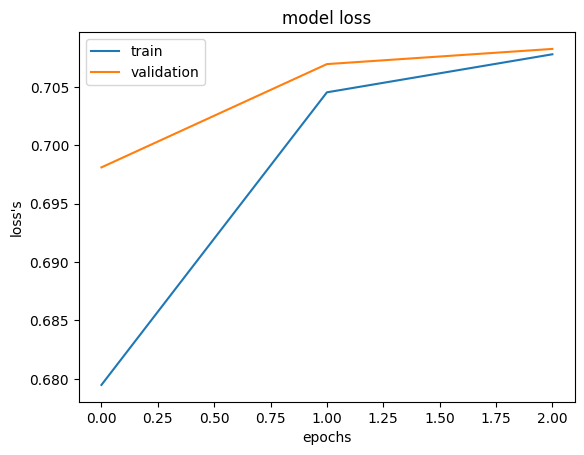

In [7]:
# Show loss finction
plt.plot(hist.history["loss"], label='train')
plt.plot(hist.history["val_loss"], label='validation')
plt.title("model loss")
plt.ylabel("loss's")
plt.xlabel("epochs")
plt.legend(loc="upper left")
plt.show()

In [21]:
# predict the rating dataset
df_test = pd.read_csv(test_path)

df_test['userId'] = df_test['userId'].map(encoder)
df_test.tail()

,userId,itemId,date
131353,8611328,388934,2021-07-30 08:48:06
131354,8611328,571188,2021-07-30 08:49:17
131355,8611328,707682,2021-07-30 08:49:40
131356,8611328,44761,2021-07-30 08:48:55
131357,8611328,699794,2021-07-30 14:21:08


In [23]:
df_test = DoingPreprocessingValues(df, testing=True)
df_test.head()

,userId,itemId,date,user,item
0,500,857869,2021-08-18 00:40:19,0,559
1,500,631765,2021-08-18 01:31:23,0,1583
2,500,232633,2021-08-18 01:12:46,0,2190
3,500,259982,2021-08-18 00:50:49,0,1584
4,500,131945,2021-08-18 00:56:13,0,1232


In [24]:
X_forcast = df_test[['user', 'item']].values
print(f"Shape of X_forcast {X_forcast.shape}")

Shape of X_forcast (131358, 2)


In [25]:
y_pred = model.predict(X_forcast)
y_invert_pred = InverstMinMaxScalerValue(y, df)

y_invert_pred[:10]

4105/4105 [==============================] - 10s 2ms/step


array([4., 4., 4., 5., 4., 4., 3., 5., 4., 5.])

In [26]:
df_res = pd.DataFrame(columns=['prediction'])
df_res['prediction'] = y_invert_pred
df_res.tail(10)

,prediction
8612097,3.0
8612098,4.0
8612099,1.0
8612100,3.0
8612101,4.0
8612102,1.0
8612103,4.0
8612104,3.0
8612105,4.0
8612106,4.0


In [27]:
df_res.to_csv('output.csv')
!cp output.csv "drive/My Drive/"